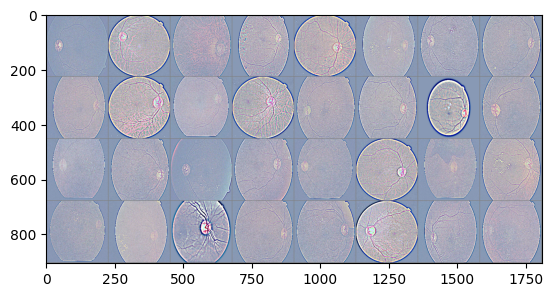

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


finished training
Accuracy: 95.09%
Class: Healthy,Precision: 99.36, Recall: 97.98
Class: Mild DR,Precision: 86.19, Recall: 95.67
Class: Moderate DR,Precision: 99.10, Recall: 91.66
Class: Proliferative DR,Precision: 94.27, Recall: 92.64
Class: Severe DR,Precision: 80.21, Recall: 98.72
Confusion Matrix:
[[778  14   2   0   0]
 [  5 287   2   2   4]
 [  0  31 659   9  20]
 [  0   1   2 214  14]
 [  0   0   0   2 154]]


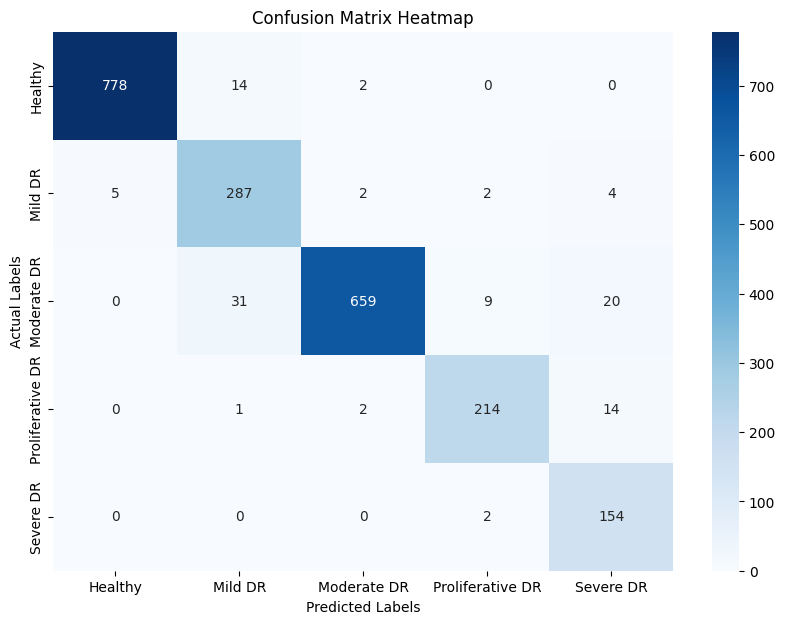

Predicted DR Severity: Healthy


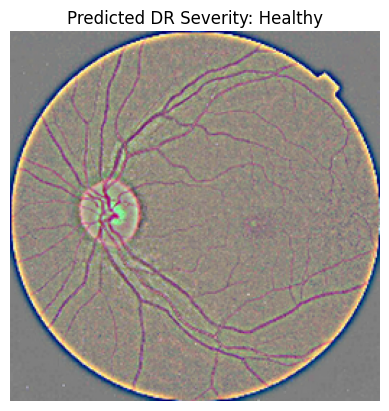

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.utils as utils
from torch.utils.data import DataLoader,random_split
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#HyperParameters
batch_size=32
learning_rate=0.001
num_epochs=10

path_dir='/kaggle/input/diabetic-retinopathy-dataset'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

full_dataset = datasets.ImageFolder(root=path_dir,transform=transform)
train_size = int(0.8*len(full_dataset))
test_size = len(full_dataset)-train_size

train_dataset,test_dataset = random_split(full_dataset,[train_size,test_size])

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

classes = ('Healthy','Mild DR','Moderate DR','Proliferative DR','Severe DR')

def imshow(img):
  img = img/2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()

dataiter = iter(train_loader)
images,labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

model=models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
  running_loss = 0.0
  model.train()

  for i,(inputs,labels) in enumerate(train_loader):
     inputs = inputs.to(device)
     labels = labels.to(device)

     outputs=model(inputs)
     loss = criterion(outputs,labels)

     optimizer.zero_grad()
     loss.backward()
     optimizer.step()

     running_loss += loss.item()
     if (i+1) % 500 == 0:
       print(f'[{epoch+1},{i+1}] loss:{running_loss/1000:.3f}')
       running_loss = 0.0

print("finished training")

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

# Precision and recall
precision = precision_score(all_labels, all_preds, average=None)
recall = recall_score(all_labels, all_preds, average=None)
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy * 100:.2f}%')

for i, class_name in enumerate(classes):
    print(f'Class: {class_name},Precision: {precision[i]*100:.2f}, Recall: {recall[i]*100:.2f}')

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')
print(conf_matrix)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)

# Labels, title and ticks
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

image_path='/kaggle/input/diabetic-retinopathy-dataset/Healthy/Healthy.png'
image=Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    output=model(input_tensor)
    _,predicted_class= torch.max(output,1)

predicted_label = classes[predicted_class.item()]
print(f"Predicted DR Severity: {predicted_label}")

plt.imshow(image)
plt.title(f"Predicted DR Severity: {predicted_label}")
plt.axis("off")
plt.show()



